In [14]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.signal import find_peaks
import json
import pandas as pd
import tqdm

In [15]:
datadir = '/Users/dkakkad/work/research_projects/Triple_AGN_MUSE/'
raw_file = datadir+'data/DATACUBE_FINAL_28feb2023.fits'
cont_file = datadir+'analysis/continuum_fit/J0849_1114_continuum_20231102.fits'
z = 0.07758
save_as_pd = False
outfile = 'test_20231218.fits'

In [16]:
# Load the science data from the raw cube
input_cube = fits.open(raw_file)
sci_hdr = input_cube[1].header
sci_data = input_cube[1].data
Nz,Ny,Nx = np.shape(sci_data)
print(np.shape(sci_data))

(3201, 362, 356)


In [17]:
crpix = sci_hdr["CRPIX3"]
crval = sci_hdr["CRVAL3"]
cdel  = sci_hdr["CD3_3"]
wl = (np.linspace(1,Nz,Nz) - crpix)*cdel + crval
wl_dr = wl/(1+z)

In [18]:
# Load the continuum cube
cont_cube = fits.open(cont_file)
cont_data = cont_cube[1].data
print(np.shape(cont_data))

(3201, 362, 356)


(4600.0, 5200.0)

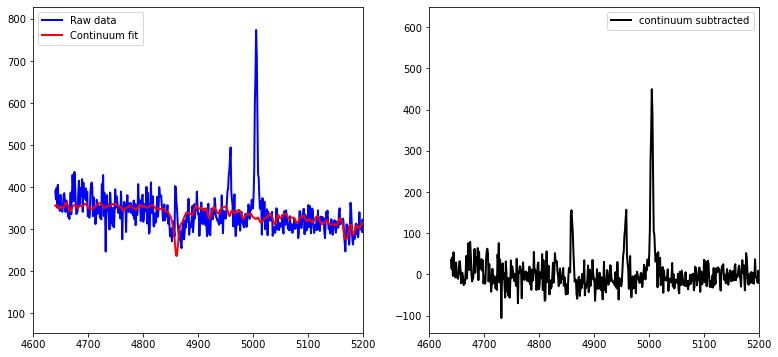

In [19]:
# Plot a spectrum from one pixel to see if the cubes were loaded properly

# Part 1: Hbeta and [OIII]

dummy_i,dummy_j = 173,172

dummy_sci_data = sci_data[:,dummy_j,dummy_i]
dummy_cont_data = cont_data[:,dummy_j,dummy_i]

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(13,6))
ax[0].plot(wl_dr, dummy_sci_data, linewidth=2.,color='blue',label='Raw data')
ax[0].plot(wl_dr, dummy_cont_data, linewidth=2.,color='red', label='Continuum fit')
ax[0].legend()
ax[0].set_xlim(4600,5200)

ax[1].plot(wl_dr, dummy_sci_data-dummy_cont_data, linewidth=2.,color='black', label='continuum subtracted')
ax[1].legend()
ax[1].set_xlim(4600,5200)

(6200.0, 6800.0)

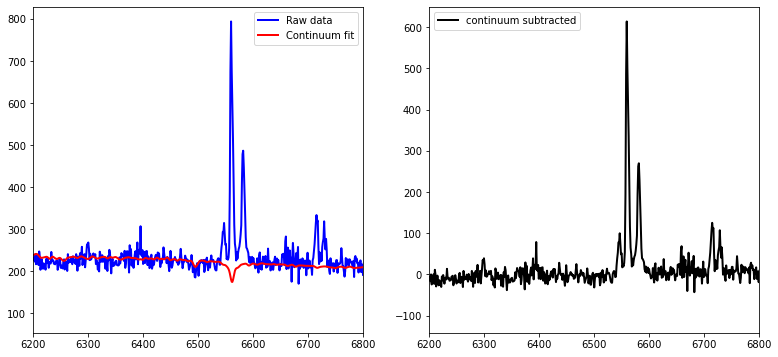

In [20]:
# Part 2: OI, Halpha, NII and SII

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(13,6))
ax[0].plot(wl_dr, dummy_sci_data, linewidth=2.,color='blue',label='Raw data')
ax[0].plot(wl_dr, dummy_cont_data, linewidth=2.,color='red', label='Continuum fit')
ax[0].legend()
ax[0].set_xlim(6200,6800)

ax[1].plot(wl_dr, dummy_sci_data-dummy_cont_data, linewidth=2.,color='black', label='continuum subtracted')
ax[1].legend()
ax[1].set_xlim(6200,6800)

In [21]:
# Subtract the continuum
cont_sub = sci_data-cont_data

In [22]:
# import line lists
line_list_file = open('line_list.json')
line_list = json.load(line_list_file)
optical_lines = line_list['optical'][0]
Hbeta = optical_lines['Hbeta']
oiii4959 = optical_lines['oiii4959']
oiii5007 = optical_lines['oiii5007']
oi6300 = optical_lines['oi6300']
oi6363 = optical_lines['oi6363']
nii6548 = optical_lines['nii6548']
Halpha = optical_lines['Halpha']
nii6583 = optical_lines['nii6583']
sii6716 = optical_lines['sii6716']
sii6731 = optical_lines['sii6731']

In [23]:
def mygauss(x,*params):
        gauss_terms = params[2] * np.exp(-(x - params[0])**2/(2*params[1]**2))
        return gauss_terms

def model_function(x,*p):
    """
    Fit the optical lines in the MUSE spectrum
    """
    continuum = p[0] + p[1]*x
    oiii5007_model = mygauss(x,p[2],p[3],p[4])
    oiii4959_model = mygauss(x,p[2]-(oiii5007-oiii4959),p[3],p[4]/3)
    Hbeta_model = mygauss(x,p[2]-(oiii5007-Hbeta),p[3],p[5])
    oi6300_model = mygauss(x,p[2]-(oiii5007-oi6300),p[3],p[6])
    oi6363_model = mygauss(x,p[2]-(oiii5007-oi6363),p[3],p[7])
    
    Halpha_model = mygauss(x,p[8],p[9],p[10])
    nii6548_model = mygauss(x,p[8]-(Halpha-nii6548),p[9],p[11]/3)
    nii6583_model = mygauss(x,p[8]-(Halpha-nii6583),p[9],p[11])
    sii6716_model = mygauss(x,p[8]-(Halpha-sii6716),p[9],p[12])
    sii6731_model = mygauss(x,p[8]-(Halpha-sii6731),p[9],p[13])
    full_model = continuum+oiii5007_model+oiii4959_model+Hbeta_model+oi6300_model+\
                 oi6363_model+nii6548_model+Halpha_model+nii6583_model+sii6716_model+\
                 sii6731_model
    return full_model

def fit_gaussian(function,freq,intspec):
    """
    Fit the model to the spectrum
    """
    guess = [0.0,0.6,oiii5007,1.7,1.0,0.2,0.2,0.2,Halpha,1.7,1.0,0.3,0.3,0.4]
    bounds_low = [-np.inf,-np.inf,oiii5007-10,0.35,0.,0.,0.,0.,Halpha-10,0.35,0.,0.,0.,0.]
    bounds_high = [np.inf,np.inf,oiii5007+10,14,np.inf,np.inf,np.inf,np.inf,Halpha+10,14,np.inf,np.inf,np.inf,np.inf]
    intspec[np.isnan(intspec)] = 0
    try:
        popt, pcov = curve_fit(function,freq,intspec,
                                p0=guess,bounds=[bounds_low,bounds_high])
    except RuntimeError:
        print("Fit failed")
        popt = np.zeros(len(guess))
    return popt

In [24]:
filt = (4700 <= wl_dr) & (wl_dr <= 7000)
cont_sub_filt,spec_wv = cont_sub[filt,:,:],wl_dr[filt]

print(np.shape(cont_sub_filt))
print(np.shape(spec_wv))

(1983, 362, 356)
(1983,)


In [25]:
# saving the entire data into a fits format, same as the input data
cont_x0 = np.zeros((Ny,Nx))
cont_x1 = np.zeros((Ny,Nx))
oiii5007_wave = np.zeros((Ny,Nx))
oiii5007_sig = np.zeros((Ny,Nx))
oiii5007_peak = np.zeros((Ny,Nx))
Hbeta_peak = np.zeros((Ny,Nx))
oi6300_peak = np.zeros((Ny,Nx))
oi6363_peak = np.zeros((Ny,Nx))
Halpha_wave = np.zeros((Ny,Nx))
Halpha_sig = np.zeros((Ny,Nx))
Halpha_peak = np.zeros((Ny,Nx))
nii6583_peak = np.zeros((Ny,Nx))
sii6716_peak = np.zeros((Ny,Nx))
sii6731_peak = np.zeros((Ny,Nx))

if save_as_pd == True:
    df = pd.DataFrame()

for i in tqdm.tqdm(range(0,Nx)):
    for j in range(0,Ny):
        spec_fl = cont_sub_filt[:,j,i]
        spec_fl_norm = spec_fl/np.max(spec_fl)
        params = fit_gaussian(model_function,spec_wv,spec_fl_norm)
        
        cont_x0[j,i] = params[0]
        cont_x1[j,i] = params[1]
        oiii5007_wave[j,i] = params[2]
        oiii5007_sig[j,i] = params[3]
        oiii5007_peak[j,i] = params[4]*np.max(spec_fl)
        Hbeta_peak[j,i] = params[5]*np.max(spec_fl)
        oi6300_peak[j,i] = params[6]*np.max(spec_fl)
        oi6363_peak[j,i] = params[7]*np.max(spec_fl)
        Halpha_wave[j,i] = params[8]
        Halpha_sig[j,i] = params[9]
        Halpha_peak[j,i] = params[10]*np.max(spec_fl)
        nii6583_peak[j,i] = params[11]*np.max(spec_fl)
        sii6716_peak[j,i] = params[12]*np.max(spec_fl)
        sii6731_peak[j,i] = params[13]*np.max(spec_fl)
        
        # keeping this bit in case pandas dataframe is to be used at some point
        #if save_as_pd == True:
        #    d = {'pixel_info': [[i,j]], 'fit_params': [params], 'spec_norm':[np.max(spec_fl)]}
        #    df = df.append(d, ignore_index=True)

  6%|██▍                                     | 22/356 [21:30<6:24:38, 69.10s/it]

Fit failed


 10%|████                                    | 36/356 [38:36<6:27:56, 72.74s/it]

Fit failed


 11%|████▍                                   | 40/356 [43:49<6:33:47, 74.77s/it]

Fit failed


 30%|███████████                          | 107/356 [2:01:23<4:41:52, 67.92s/it]

Fit failed


100%|███████████████████████████████████████| 356/356 [6:24:20<00:00, 64.78s/it]


In [26]:
new_hdul = fits.HDUList()
new_hdul.append(fits.ImageHDU(np.zeros((1,1)), name="Primary"))

new_hdul.append(fits.ImageHDU(cont_x0, name="x0"))
new_hdul.append(fits.ImageHDU(cont_x1, name="x1"))

new_hdul.append(fits.ImageHDU(oiii5007_wave, name="oiii5007_wave"))
new_hdul.append(fits.ImageHDU(oiii5007_sig, name="oiii5007_sig"))
new_hdul.append(fits.ImageHDU(oiii5007_peak, name="oiii5007_peak"))
new_hdul.append(fits.ImageHDU(Hbeta_peak, name="Hbeta_peak"))
new_hdul.append(fits.ImageHDU(oi6300_peak, name="oi6300_peak"))
new_hdul.append(fits.ImageHDU(oi6363_peak, name="oi6363_peak"))
new_hdul.append(fits.ImageHDU(Halpha_wave, name="Halpha_wave"))
new_hdul.append(fits.ImageHDU(Halpha_sig, name="Halpha_sig"))
new_hdul.append(fits.ImageHDU(Halpha_peak, name="Halpha_peak"))
new_hdul.append(fits.ImageHDU(nii6583_peak, name="nii6583_peak"))
new_hdul.append(fits.ImageHDU(sii6716_peak, name="sii6716_peak"))
new_hdul.append(fits.ImageHDU(sii6731_peak, name="sii6731_peak"))
new_hdul.writeto(outfile, overwrite=True)